In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
df = pd.read_csv('trainset/J0003_0024_0222_20110307012737_cell_1.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,1,0.259,2.23,-20
1,2011.3.7 18:29,1,0.260,2.23,-20
2,2011.3.8 6:29,1,0.259,2.23,-20
3,2011.3.8 18:29,1,0.259,2.23,-20
4,2011.3.9 6:29,1,0.259,2.23,-20
...,...,...,...,...,...
254,2011.8.30 5:28,1,0.301,2.23,-20
255,2011.8.30 17:28,1,0.301,2.23,-20
256,2011.8.31 5:28,1,0.302,2.23,-20
257,2011.8.31 16:09,1,0.300,2.23,-20


In [4]:
df = df['Resistance']
df

0      0.259
1      0.260
2      0.259
3      0.259
4      0.259
       ...  
254    0.301
255    0.301
256    0.302
257    0.300
258    0.296
Name: Resistance, Length: 259, dtype: float64

In [5]:
test_data_size = 30
train_data = df[:-test_data_size]
test_data = df[-test_data_size:]

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Resistance']
train_data = pd.DataFrame(train_data)
train_data.columns = scale_cols

train_data

,Resistance
0,0.259
1,0.260
2,0.259
3,0.259
4,0.259
...,...
224,0.294
225,0.294
226,0.295
227,0.295


In [7]:
train_data_normalized = scaler.fit_transform(train_data[scale_cols])

In [8]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [9]:
train_window = 20

In [10]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

In [11]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [12]:
train_data_normalized[:25]

tensor([0.0270, 0.0541, 0.0270, 0.0270, 0.0270, 0.0270, 0.0541, 0.0541, 0.0811,
        0.0541, 0.0541, 0.0541, 0.0811, 0.0541, 0.0541, 0.0000, 0.0000, 0.0000,
        0.0270, 0.0811, 0.0541, 0.0541, 0.1081, 0.1081, 0.1081])

In [13]:
train_inout_seq[:5]

[(tensor([0.0270, 0.0541, 0.0270, 0.0270, 0.0270, 0.0270, 0.0541, 0.0541, 0.0811,
          0.0541, 0.0541, 0.0541, 0.0811, 0.0541, 0.0541, 0.0000, 0.0000, 0.0000,
          0.0270, 0.0811]),
  tensor([0.0541])),
 (tensor([0.0541, 0.0270, 0.0270, 0.0270, 0.0270, 0.0541, 0.0541, 0.0811, 0.0541,
          0.0541, 0.0541, 0.0811, 0.0541, 0.0541, 0.0000, 0.0000, 0.0000, 0.0270,
          0.0811, 0.0541]),
  tensor([0.0541])),
 (tensor([0.0270, 0.0270, 0.0270, 0.0270, 0.0541, 0.0541, 0.0811, 0.0541, 0.0541,
          0.0541, 0.0811, 0.0541, 0.0541, 0.0000, 0.0000, 0.0000, 0.0270, 0.0811,
          0.0541, 0.0541]),
  tensor([0.1081])),
 (tensor([0.0270, 0.0270, 0.0270, 0.0541, 0.0541, 0.0811, 0.0541, 0.0541, 0.0541,
          0.0811, 0.0541, 0.0541, 0.0000, 0.0000, 0.0000, 0.0270, 0.0811, 0.0541,
          0.0541, 0.1081]),
  tensor([0.1081])),
 (tensor([0.0270, 0.0270, 0.0541, 0.0541, 0.0811, 0.0541, 0.0541, 0.0541, 0.0811,
          0.0541, 0.0541, 0.0000, 0.0000, 0.0000, 0.0270, 0.0811, 

In [14]:
class GRU(nn.Module):
    def __init__(self, input_size=1, output_size=1):
        super(GRU, self).__init__()
        self.hidden_layer_size = 128
        
        self.gru = nn.GRU(1, 128)
        self.lin1 = nn.Linear(128,64)
        self.lin2 = nn.Linear(64,32)
        self.lin3 = nn.Linear(32,1)
        
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        gru_out, self.hidden_cell = self.gru(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        pred1 = self.lin1(gru_out.view(len(input_seq), -1))
        pred2 = self.lin2(pred1.view(len(input_seq), -1))
        predictions = self.lin3(pred2.view(len(input_seq), -1))
        return predictions[-1]

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
model = GRU().to(device)
print(model)

Using cuda device
GRU(
  (gru): GRU(1, 128)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=1, bias=True)
)


In [16]:
model = GRU()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
epochs = 100

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size))
        
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%10 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00015863
epoch:  11 loss: 0.00000088
epoch:  21 loss: 0.00022575
epoch:  31 loss: 0.00011631
epoch:  41 loss: 0.00010295
epoch:  51 loss: 0.00011143
epoch:  61 loss: 0.00017789
epoch:  71 loss: 0.00075944
epoch:  81 loss: 0.00046294
epoch:  91 loss: 0.00005070
epoch:  99 loss: 0.0000145056


In [18]:
fut_pred = len(train_data_normalized) - train_window - 1
print(fut_pred)
print(len(train_data_normalized))
test_inputs = train_data_normalized[:train_window].tolist()
print(test_inputs)

208
229
[0.027027027681469917, 0.054054055362939835, 0.027027027681469917, 0.027027027681469917, 0.027027027681469917, 0.027027027681469917, 0.054054055362939835, 0.054054055362939835, 0.0810810774564743, 0.054054055362939835, 0.054054055362939835, 0.054054055362939835, 0.0810810774564743, 0.054054055362939835, 0.054054055362939835, 0.0, 0.0, 0.0, 0.027027027681469917, 0.0810810774564743]


In [19]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(train_data_normalized[i:i+(train_window)].tolist())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
        
print(len(test_inputs))

228


In [20]:
test_inputs[:20]

[0.027027027681469917,
 0.054054055362939835,
 0.027027027681469917,
 0.027027027681469917,
 0.027027027681469917,
 0.027027027681469917,
 0.054054055362939835,
 0.054054055362939835,
 0.0810810774564743,
 0.054054055362939835,
 0.054054055362939835,
 0.054054055362939835,
 0.0810810774564743,
 0.054054055362939835,
 0.054054055362939835,
 0.0,
 0.0,
 0.0,
 0.027027027681469917,
 0.0810810774564743]

In [21]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))
print(actual_predictions)

[[0.2867511 ]
 [0.28654295]
 [0.28599847]
 [0.2862453 ]
 [0.28572106]
 [0.28500746]
 [0.28424548]
 [0.28293636]
 [0.28080166]
 [0.28045005]
 [0.27833876]
 [0.27201836]
 [0.26335952]
 [0.26244979]
 [0.26199385]
 [0.26070811]
 [0.26170771]
 [0.26224937]
 [0.26196659]
 [0.26177725]
 [0.26268261]
 [0.26200522]
 [0.26443765]
 [0.26463884]
 [0.26444491]
 [0.26447194]
 [0.26475647]
 [0.26575447]
 [0.26566479]
 [0.26637188]
 [0.26703473]
 [0.26705376]
 [0.26717204]
 [0.26653821]
 [0.2660502 ]
 [0.26629266]
 [0.26785372]
 [0.26837321]
 [0.26816093]
 [0.26738192]
 [0.26760123]
 [0.26926127]
 [0.26921776]
 [0.26849245]
 [0.26782021]
 [0.26799607]
 [0.26889134]
 [0.26819556]
 [0.26896346]
 [0.26947808]
 [0.26869875]
 [0.26881188]
 [0.26950677]
 [0.26878632]
 [0.26893886]
 [0.26821231]
 [0.26904984]
 [0.26899512]
 [0.27042449]
 [0.27015429]
 [0.26943499]
 [0.26948641]
 [0.27024567]
 [0.27030166]
 [0.27037383]
 [0.26965128]
 [0.27045166]
 [0.27043292]
 [0.27055238]
 [0.27055773]
 [0.27124688]
 [0.27

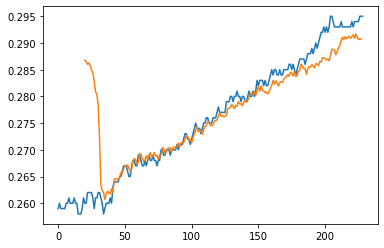

In [22]:
plt.plot(train_data)
plt.plot(range(train_window,train_window+fut_pred),actual_predictions[:,0])

In [23]:
print(train_data[train_window:-1].shape)
print(actual_predictions.shape)
print(MAPE(train_data[train_window:-1], actual_predictions[:]))

(208, 1)
(208, 1)
Resistance    1.025454
dtype: float64


258
237
Resistance    0.513361
dtype: float64


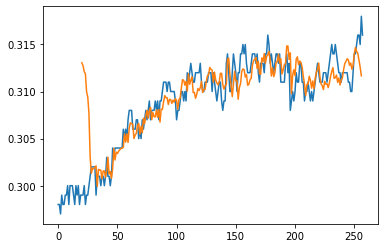

In [24]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')

test_df = test_df['Resistance']
test_data = test_df
test_data = pd.DataFrame(test_data)
test_data.columns = scale_cols
test_data_normalized = scaler.fit_transform(test_data[scale_cols])
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_inputs = test_data_normalized[:train_window].tolist()
fut_pred = len(test_data_normalized) - train_window - 1
print(len(test_data_normalized))
print(fut_pred)

for i in range(fut_pred):
    seq = torch.FloatTensor(test_data_normalized[i:i+(train_window)].tolist())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))

print(MAPE(test_data[train_window:-1], actual_predictions[:]))

plt.plot(test_df)
plt.plot(range(train_window, train_window+fut_pred), actual_predictions[:,0])

256
235
Resistance    2.982511
dtype: float64


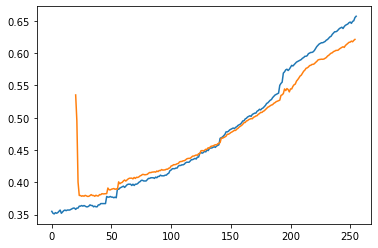

In [25]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')

test_df = test_df['Resistance']
test_data = test_df
test_data = pd.DataFrame(test_data)
test_data.columns = scale_cols
test_data_normalized = scaler.fit_transform(test_data[scale_cols])
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_inputs = test_data_normalized[:train_window].tolist()
fut_pred = len(test_data_normalized) - train_window - 1
print(len(test_data_normalized))
print(fut_pred)

for i in range(fut_pred):
    seq = torch.FloatTensor(test_data_normalized[i:i+(train_window)].tolist())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))

print(MAPE(test_data[train_window:-1], actual_predictions[:]))

plt.plot(test_df)
plt.plot(range(train_window, train_window+fut_pred), actual_predictions[:,0])

255
234
Resistance    5.488533
dtype: float64


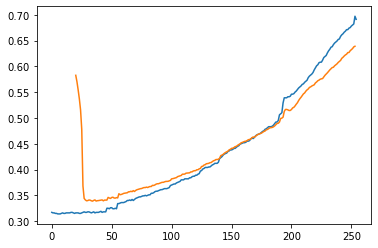

In [26]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')

test_df = test_df['Resistance']
test_data = test_df
test_data = pd.DataFrame(test_data)
test_data.columns = scale_cols
test_data_normalized = scaler.fit_transform(test_data[scale_cols])
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_inputs = test_data_normalized[:train_window].tolist()
fut_pred = len(test_data_normalized) - train_window - 1
print(len(test_data_normalized))
print(fut_pred)

for i in range(fut_pred):
    seq = torch.FloatTensor(test_data_normalized[i:i+(train_window)].tolist())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))

print(MAPE(test_data[train_window:-1], actual_predictions[:]))

plt.plot(test_df)
plt.plot(range(train_window, train_window+fut_pred), actual_predictions[:,0])

254
233
Resistance    0.74897
dtype: float64


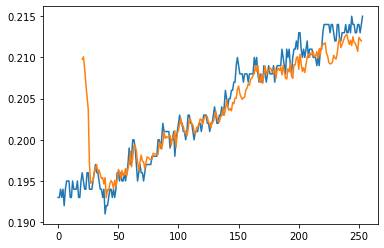

In [27]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')

test_df = test_df['Resistance']
test_data = test_df
test_data = pd.DataFrame(test_data)
test_data.columns = scale_cols
test_data_normalized = scaler.fit_transform(test_data[scale_cols])
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_inputs = test_data_normalized[:train_window].tolist()
fut_pred = len(test_data_normalized) - train_window - 1
print(len(test_data_normalized))
print(fut_pred)

for i in range(fut_pred):
    seq = torch.FloatTensor(test_data_normalized[i:i+(train_window)].tolist())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))

print(MAPE(test_data[train_window:-1], actual_predictions[:]))

plt.plot(test_df)
plt.plot(range(train_window, train_window+fut_pred), actual_predictions[:,0])

252
231
Resistance    2.130739
dtype: float64


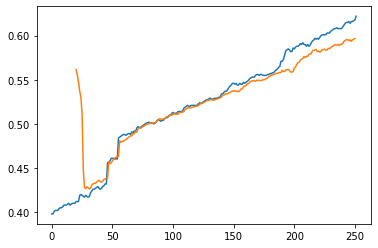

In [28]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')

test_df = test_df['Resistance']
test_data = test_df
test_data = pd.DataFrame(test_data)
test_data.columns = scale_cols
test_data_normalized = scaler.fit_transform(test_data[scale_cols])
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_inputs = test_data_normalized[:train_window].tolist()
fut_pred = len(test_data_normalized) - train_window - 1
print(len(test_data_normalized))
print(fut_pred)

for i in range(fut_pred):
    seq = torch.FloatTensor(test_data_normalized[i:i+(train_window)].tolist())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))

print(MAPE(test_data[train_window:-1], actual_predictions[:]))

plt.plot(test_df)
plt.plot(range(train_window, train_window+fut_pred), actual_predictions[:,0])

252
231
Resistance    0.525907
dtype: float64


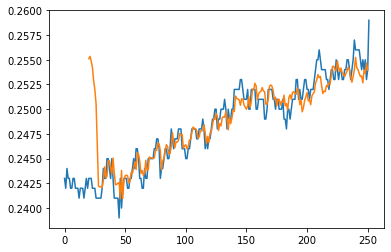

In [29]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')

test_df = test_df['Resistance']
test_data = test_df
test_data = pd.DataFrame(test_data)
test_data.columns = scale_cols
test_data_normalized = scaler.fit_transform(test_data[scale_cols])
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_inputs = test_data_normalized[:train_window].tolist()
fut_pred = len(test_data_normalized) - train_window - 1
print(len(test_data_normalized))
print(fut_pred)

for i in range(fut_pred):
    seq = torch.FloatTensor(test_data_normalized[i:i+(train_window)].tolist())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))

print(MAPE(test_data[train_window:-1], actual_predictions[:]))

plt.plot(test_df)
plt.plot(range(train_window, train_window+fut_pred), actual_predictions[:,0])

252
231
Resistance    0.722148
dtype: float64


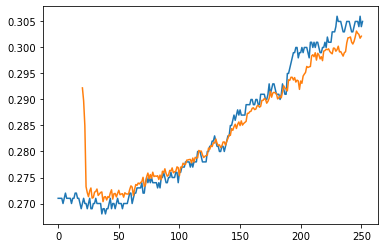

In [30]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')

test_df = test_df['Resistance']
test_data = test_df
test_data = pd.DataFrame(test_data)
test_data.columns = scale_cols
test_data_normalized = scaler.fit_transform(test_data[scale_cols])
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_inputs = test_data_normalized[:train_window].tolist()
fut_pred = len(test_data_normalized) - train_window - 1
print(len(test_data_normalized))
print(fut_pred)

for i in range(fut_pred):
    seq = torch.FloatTensor(test_data_normalized[i:i+(train_window)].tolist())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))

print(MAPE(test_data[train_window:-1], actual_predictions[:]))

plt.plot(test_df)
plt.plot(range(train_window, train_window+fut_pred), actual_predictions[:,0])

251
230
Resistance    0.608344
dtype: float64


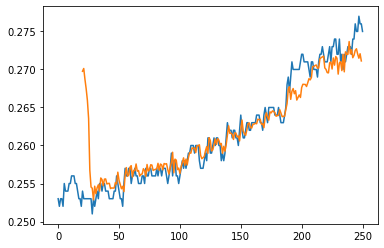

In [33]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')

test_df = test_df['Resistance']
test_data = test_df
test_data = pd.DataFrame(test_data)
test_data.columns = scale_cols
test_data_normalized = scaler.fit_transform(test_data[scale_cols])
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_inputs = test_data_normalized[:train_window].tolist()
fut_pred = len(test_data_normalized) - train_window - 1
print(len(test_data_normalized))
print(fut_pred)

for i in range(fut_pred):
    seq = torch.FloatTensor(test_data_normalized[i:i+(train_window)].tolist())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))

print(MAPE(test_data[train_window:-1], actual_predictions[:]))

plt.plot(test_df)
plt.plot(range(train_window, train_window+fut_pred), actual_predictions[:,0])

251
230
Resistance    2.360894
dtype: float64


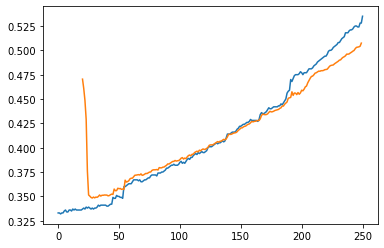

In [34]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')

test_df = test_df['Resistance']
test_data = test_df
test_data = pd.DataFrame(test_data)
test_data.columns = scale_cols
test_data_normalized = scaler.fit_transform(test_data[scale_cols])
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_inputs = test_data_normalized[:train_window].tolist()
fut_pred = len(test_data_normalized) - train_window - 1
print(len(test_data_normalized))
print(fut_pred)

for i in range(fut_pred):
    seq = torch.FloatTensor(test_data_normalized[i:i+(train_window)].tolist())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))

print(MAPE(test_data[train_window:-1], actual_predictions[:]))

plt.plot(test_df)
plt.plot(range(train_window, train_window+fut_pred), actual_predictions[:,0])